In [2]:
import keras
# from tensorflow.keras import layers
import scipy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, LeakyReLU

from keras import callbacks
from keras.datasets import mnist
from tensorflow.keras.optimizers import RMSprop, SGD
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from keras.callbacks import ModelCheckpoint, EarlyStopping




%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

tf.Tensor(352.72546, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# <font color=maroon>Model Building (Baseline) - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # normalization
    image = image/255.0
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 128
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet')
pre_model.trainable = False
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Test')

model.add(tf.keras.layers.Rescaling(scale=255))
# model.add(tf.keras.layers.TimeDistributed(pre_model))
model.add(pre_model)
model.add(Dense(10))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

# model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'))

Epoch 1/50

391/391 [==============================] - 102s 242ms/step - loss: 0.5921 - accuracy: 0.8136 - val_loss: 0.3614 - val_accuracy: 0.8825

Epoch 2/50

391/391 [==============================] - 91s 231ms/step - loss: 0.3493 - accuracy: 0.8816 - val_loss: 0.3155 - val_accuracy: 0.8953

Epoch 3/50

391/391 [==============================] - 90s 231ms/step - loss: 0.3099 - accuracy: 0.8948 - val_loss: 0.2972 - val_accuracy: 0.9006

Epoch 4/50

391/391 [==============================] - 90s 231ms/step - loss: 0.2870 - accuracy: 0.9016 - val_loss: 0.2849 - val_accuracy: 0.9053

Epoch 5/50

391/391 [==============================] - 91s 231ms/step - loss: 0.2727 - accuracy: 0.9069 - val_loss: 0.2772 - val_accuracy: 0.9063

Epoch 6/50

391/391 [==============================] - 90s 231ms/step - loss: 0.2612 - accuracy: 0.9107 - val_loss: 0.2745 - val_accuracy: 0.9073

Epoch 7/50

391/391 [==============================] - 91s 233ms/step - loss: 0.2517 - accuracy: 0.9132 - val_loss: 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

79/79 [==============================] - 15s 194ms/step - loss: 0.2693 - accuracy: 0.9107

Test loss:  0.26925134658813477

Test accuracy: 0.9107000231742859


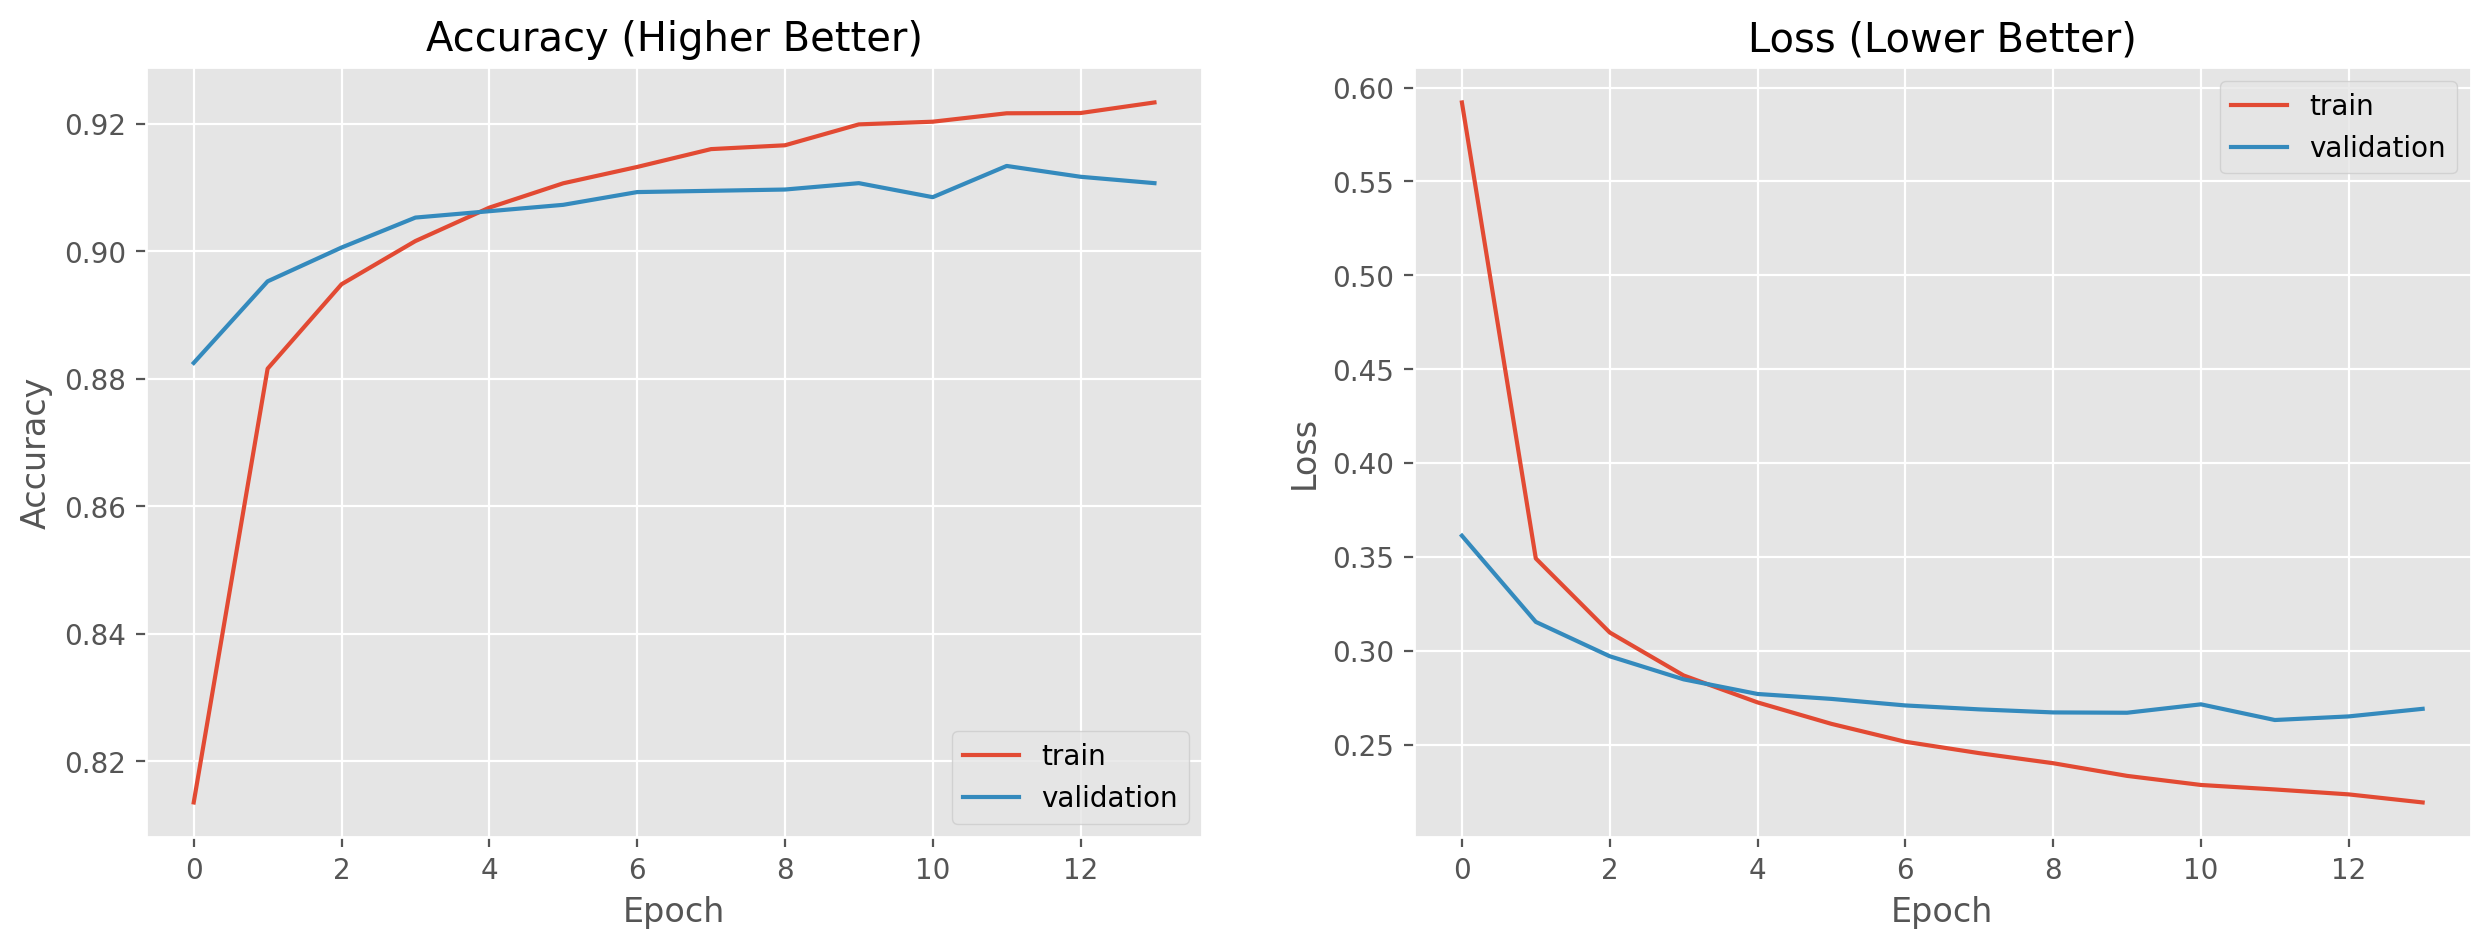

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

79/79 [==============================] - 17s 190ms/step

[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


C:\Users\mctro\AppData\Local\Temp\ipykernel_8788\2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


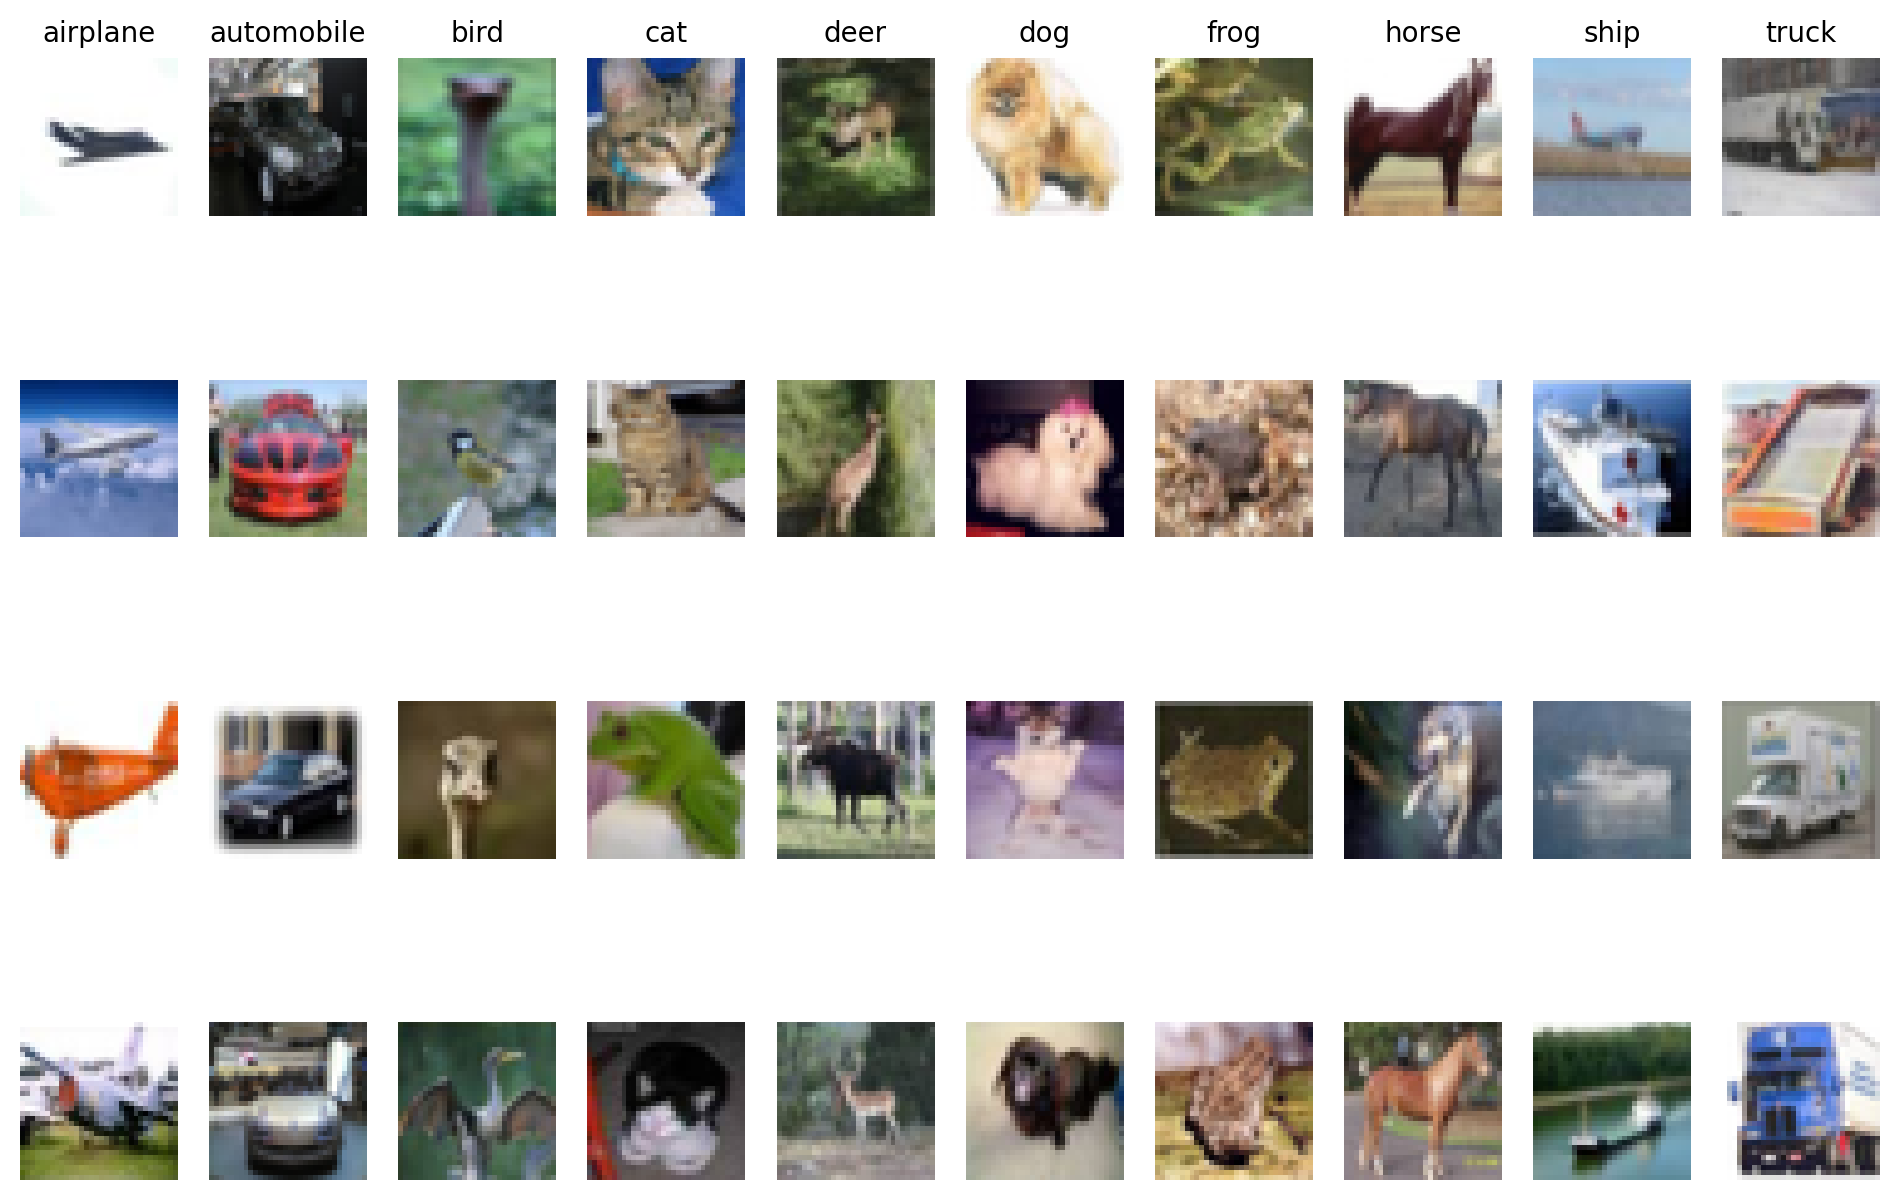

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 1 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_1')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

# model.summary()

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'))

Epoch 1/50

782/782 [==============================] - 196s 188ms/step - loss: 0.3326 - accuracy: 0.8882 - val_loss: 0.4454 - val_accuracy: 0.8551

Epoch 2/50

782/782 [==============================] - 145s 186ms/step - loss: 0.1668 - accuracy: 0.9428 - val_loss: 0.2401 - val_accuracy: 0.9261

Epoch 3/50

782/782 [==============================] - 145s 185ms/step - loss: 0.1280 - accuracy: 0.9565 - val_loss: 0.2540 - val_accuracy: 0.9207

Epoch 4/50

782/782 [==============================] - 145s 185ms/step - loss: 0.1062 - accuracy: 0.9631 - val_loss: 0.3172 - val_accuracy: 0.9144

Epoch 5/50

782/782 [==============================] - 145s 186ms/step - loss: 0.0909 - accuracy: 0.9688 - val_loss: 0.2400 - val_accuracy: 0.9306

Epoch 6/50

782/782 [==============================] - 145s 185ms/step - loss: 0.0777 - accuracy: 0.9727 - val_loss: 0.3192 - val_accuracy: 0.9189

Epoch 7/50

782/782 [==============================] - 145s 185ms/step - loss: 0.0712 - accuracy: 0.9756 - val_l

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 40ms/step - loss: 0.2360 - accuracy: 0.9449

Test loss:  0.2360343039035797

Test accuracy: 0.9448999762535095


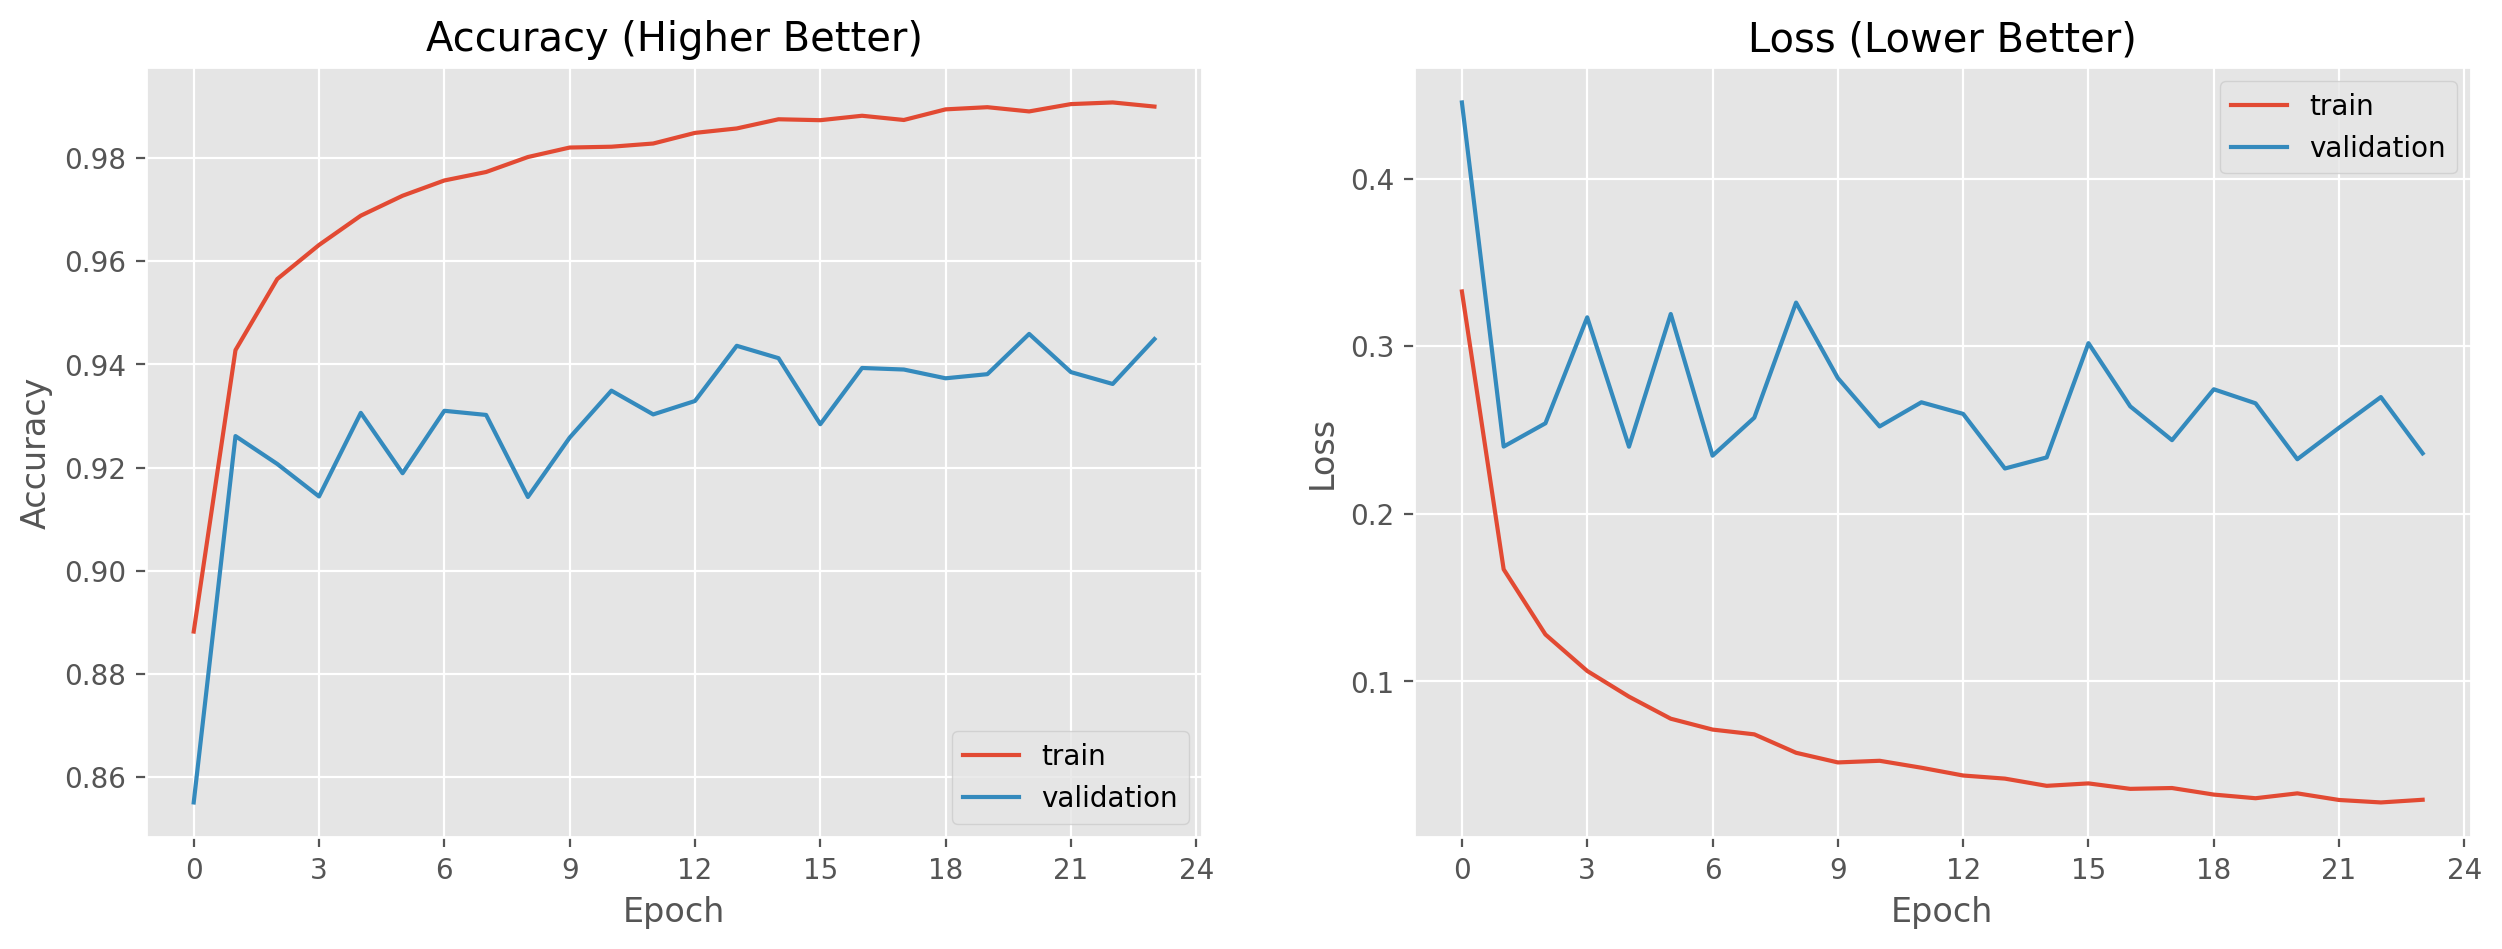

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 7s 36ms/step

[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-12-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


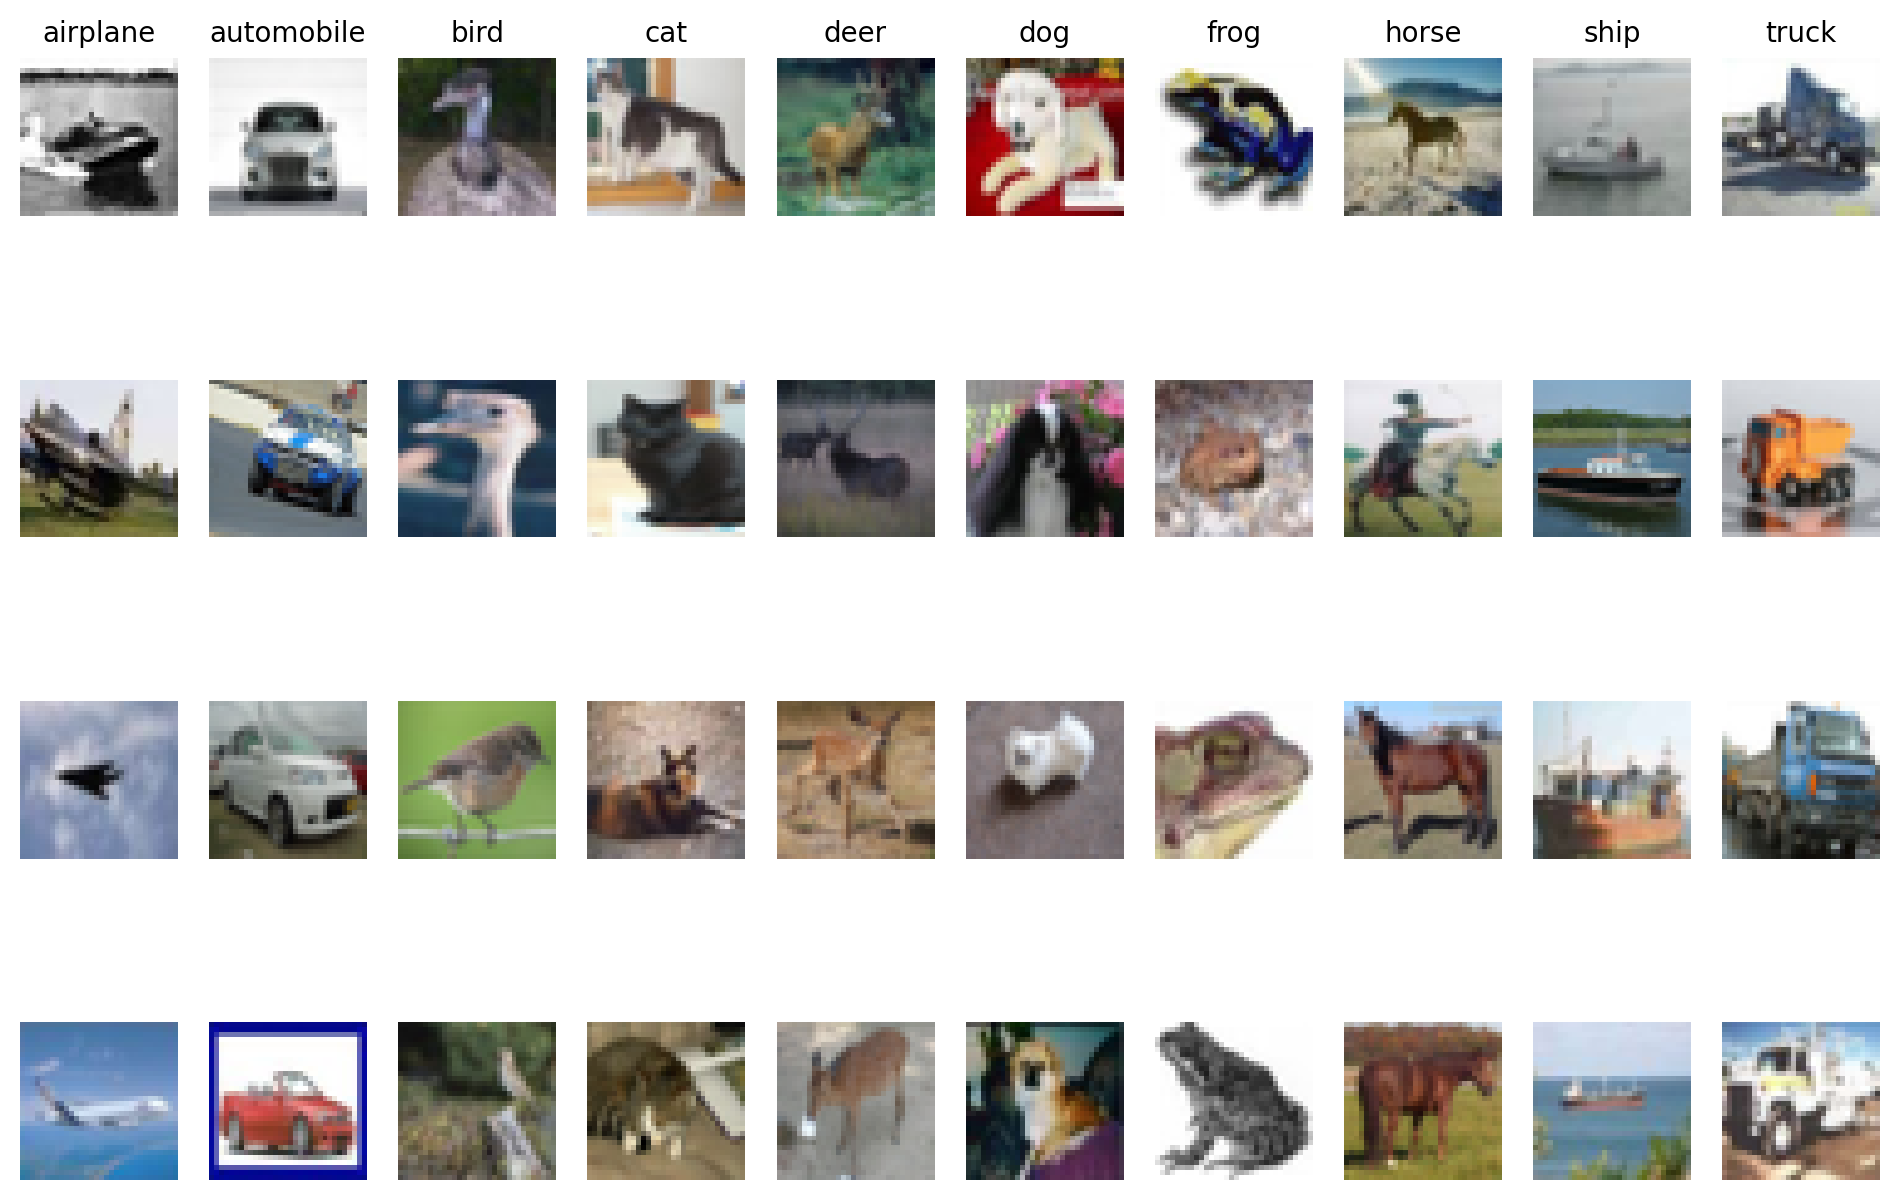

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 2 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_2')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Epoch 1/50

782/782 [==============================] - 196s 189ms/step - loss: 2.0135 - accuracy: 0.3376 - val_loss: 1.5558 - val_accuracy: 0.6235 - lr: 3.2258e-06

Epoch 2/50

782/782 [==============================] - 145s 185ms/step - loss: 1.2635 - accuracy: 0.6935 - val_loss: 0.8895 - val_accuracy: 0.7897 - lr: 3.2258e-06

Epoch 3/50

782/782 [==============================] - 145s 185ms/step - loss: 0.8038 - accuracy: 0.7926 - val_loss: 0.5858 - val_accuracy: 0.8460 - lr: 3.2258e-06

Epoch 4/50

782/782 [==============================] - 145s 185ms/step - loss: 0.5881 - accuracy: 0.8347 - val_loss: 0.4397 - val_accuracy: 0.8738 - lr: 3.2258e-06

Epoch 5/50

782/782 [==============================] - 145s 185ms/step - loss: 0.4764 - accuracy: 0.8590 - val_loss: 0.3573 - val_accuracy: 0.8946 - lr: 3.2258e-06

Epoch 6/50

782/782 [==============================] - 145s 185ms/step - loss: 0.4011 - accuracy: 0.8763 - val_loss: 0.3068 - val_accuracy: 0.9076 - lr: 3.2258e-06

Epoch 7/50

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 40ms/step - loss: 0.1171 - accuracy: 0.9622

Test loss:  0.11712684482336044

Test accuracy: 0.9621999859809875


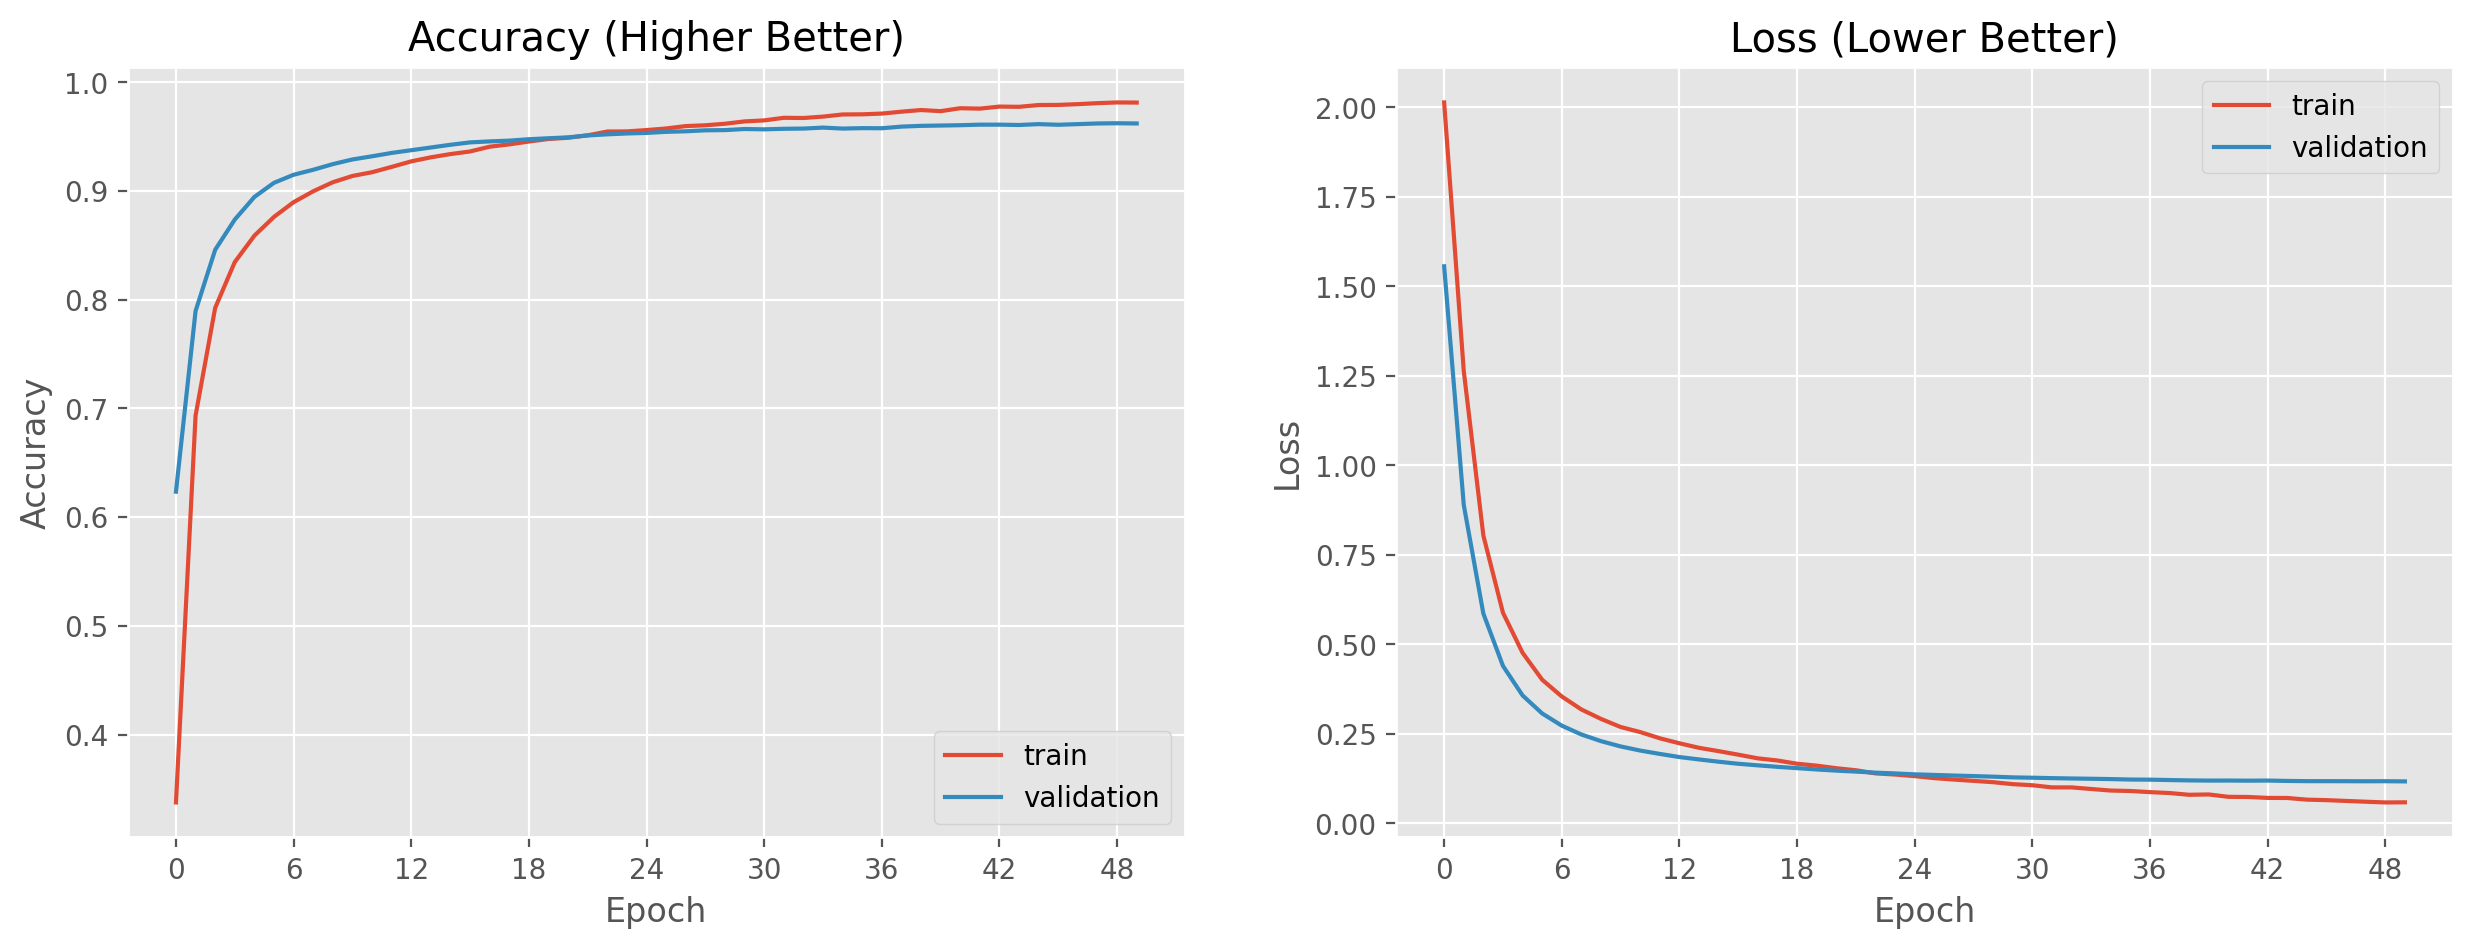

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

NameError: ignored

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 3 - Efficient Net

### Import

In [ ]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Data Preprocessing

In [ ]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

    
# Create TensorFlow dataset objects for the training and test sets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 64
# Preprocess, batch, and prefetch the datasets
train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_ds.map(format_image).batch(batch_size).prefetch(1)

print(train_set)
print(test_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.
- Increased epoch to 100 
- Increased Early Stopper to 20 

In [ ]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

Model: "efficientnetb0"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                

                                                                                                  

 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              

                                                                                                  

 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normali

In [ ]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_3')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 100

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Epoch 1/100

782/782 [==============================] - 194s 186ms/step - loss: 1.9779 - accuracy: 0.3595 - val_loss: 1.5490 - val_accuracy: 0.6159 - lr: 3.2258e-06

Epoch 2/100

782/782 [==============================] - 144s 184ms/step - loss: 1.2784 - accuracy: 0.6892 - val_loss: 0.9207 - val_accuracy: 0.7812 - lr: 3.2258e-06

Epoch 3/100

782/782 [==============================] - 143s 183ms/step - loss: 0.8235 - accuracy: 0.7888 - val_loss: 0.6022 - val_accuracy: 0.8410 - lr: 3.2258e-06

Epoch 4/100

782/782 [==============================] - 143s 183ms/step - loss: 0.5939 - accuracy: 0.8348 - val_loss: 0.4502 - val_accuracy: 0.8716 - lr: 3.2258e-06

Epoch 5/100

782/782 [==============================] - 144s 184ms/step - loss: 0.4764 - accuracy: 0.8596 - val_loss: 0.3670 - val_accuracy: 0.8923 - lr: 3.2258e-06

Epoch 6/100

782/782 [==============================] - 144s 184ms/step - loss: 0.4066 - accuracy: 0.8752 - val_loss: 0.3144 - val_accuracy: 0.9039 - lr: 3.2258e-06

Epoc

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 6s 39ms/step - loss: 0.1198 - accuracy: 0.9622

Test loss:  0.11984709650278091

Test accuracy: 0.9621999859809875


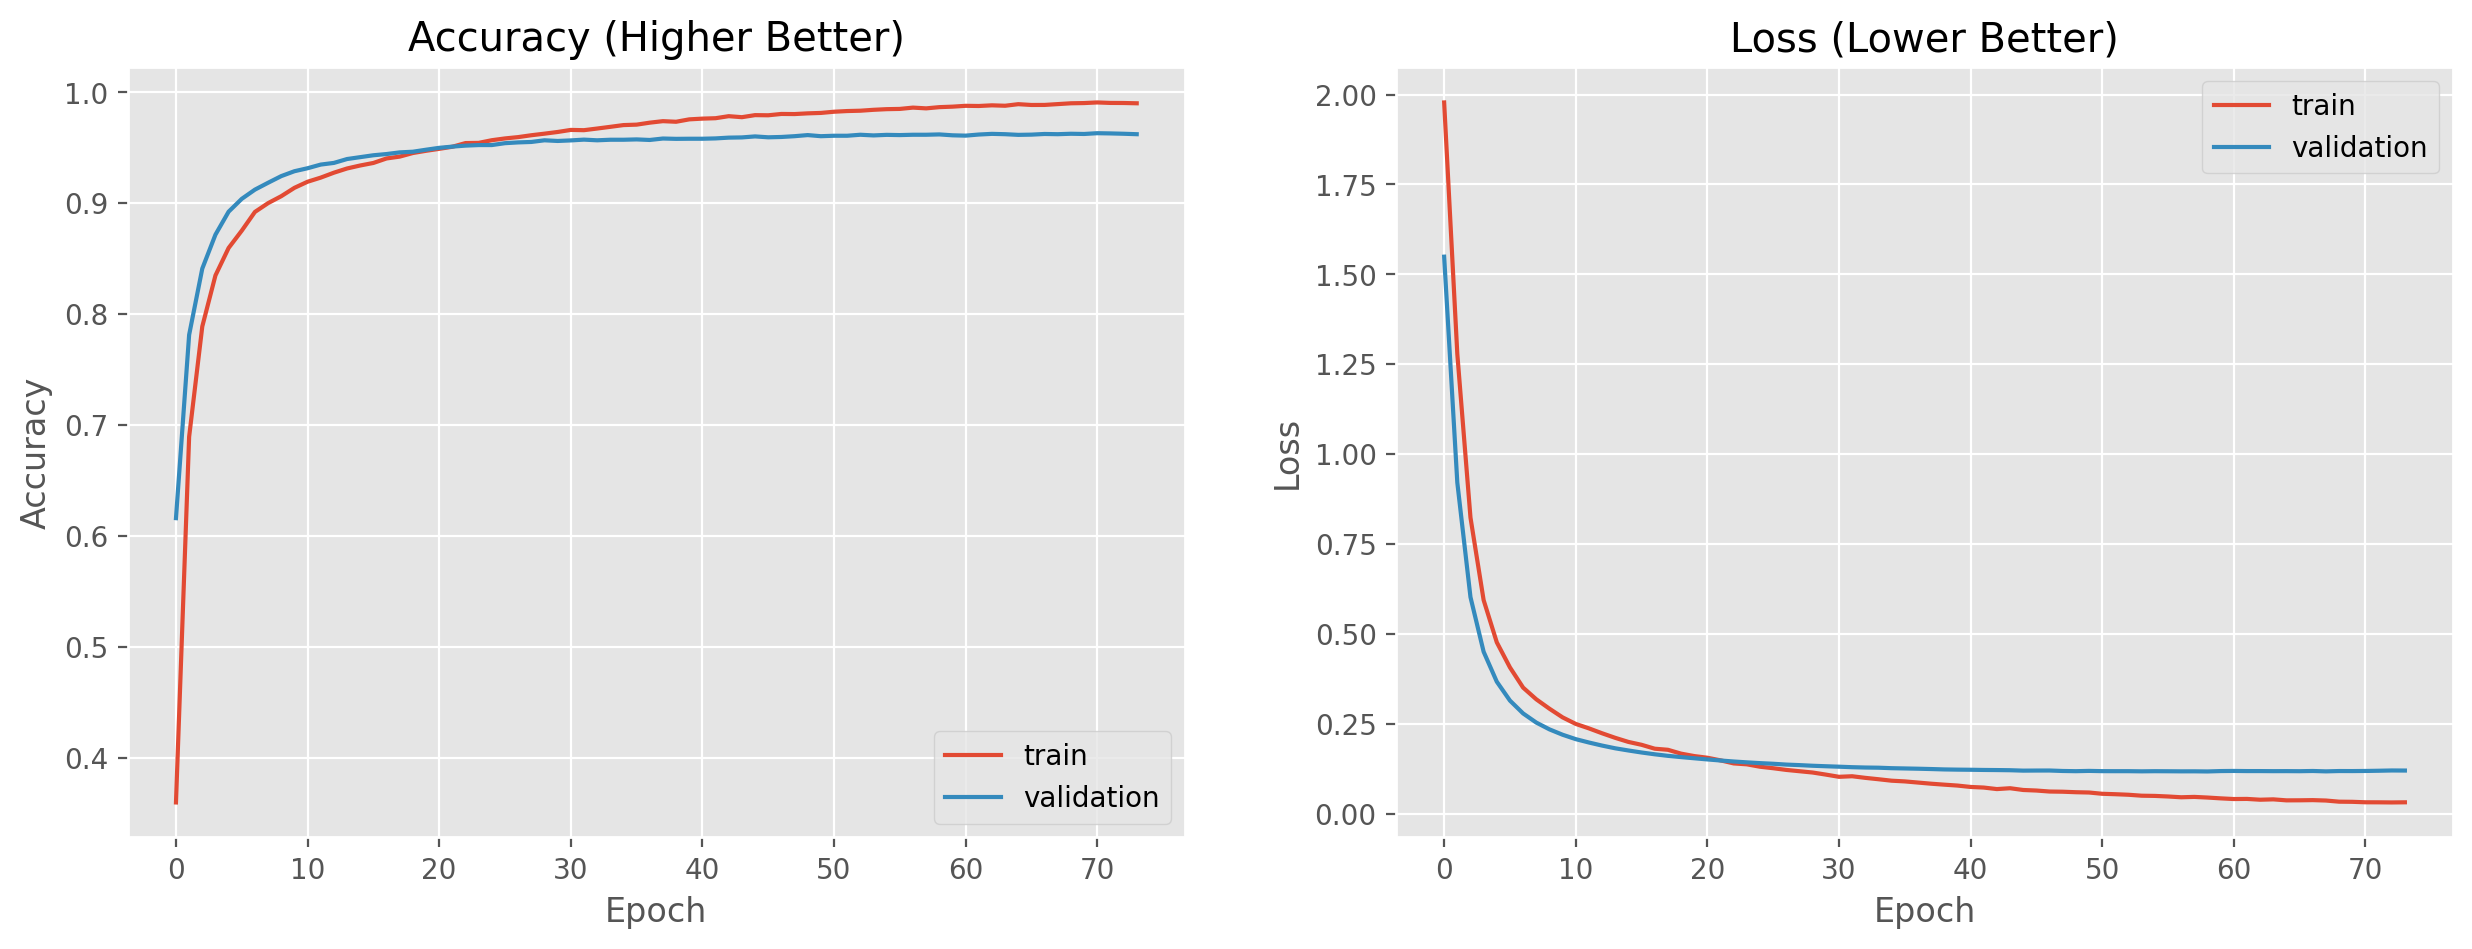

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 7s 36ms/step

[3 8 8 ... 5 1 7]


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [ ]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [ ]:
print(err_x.shape)

(1000, 32, 32, 3)


<ipython-input-12-8830efd3c24d>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


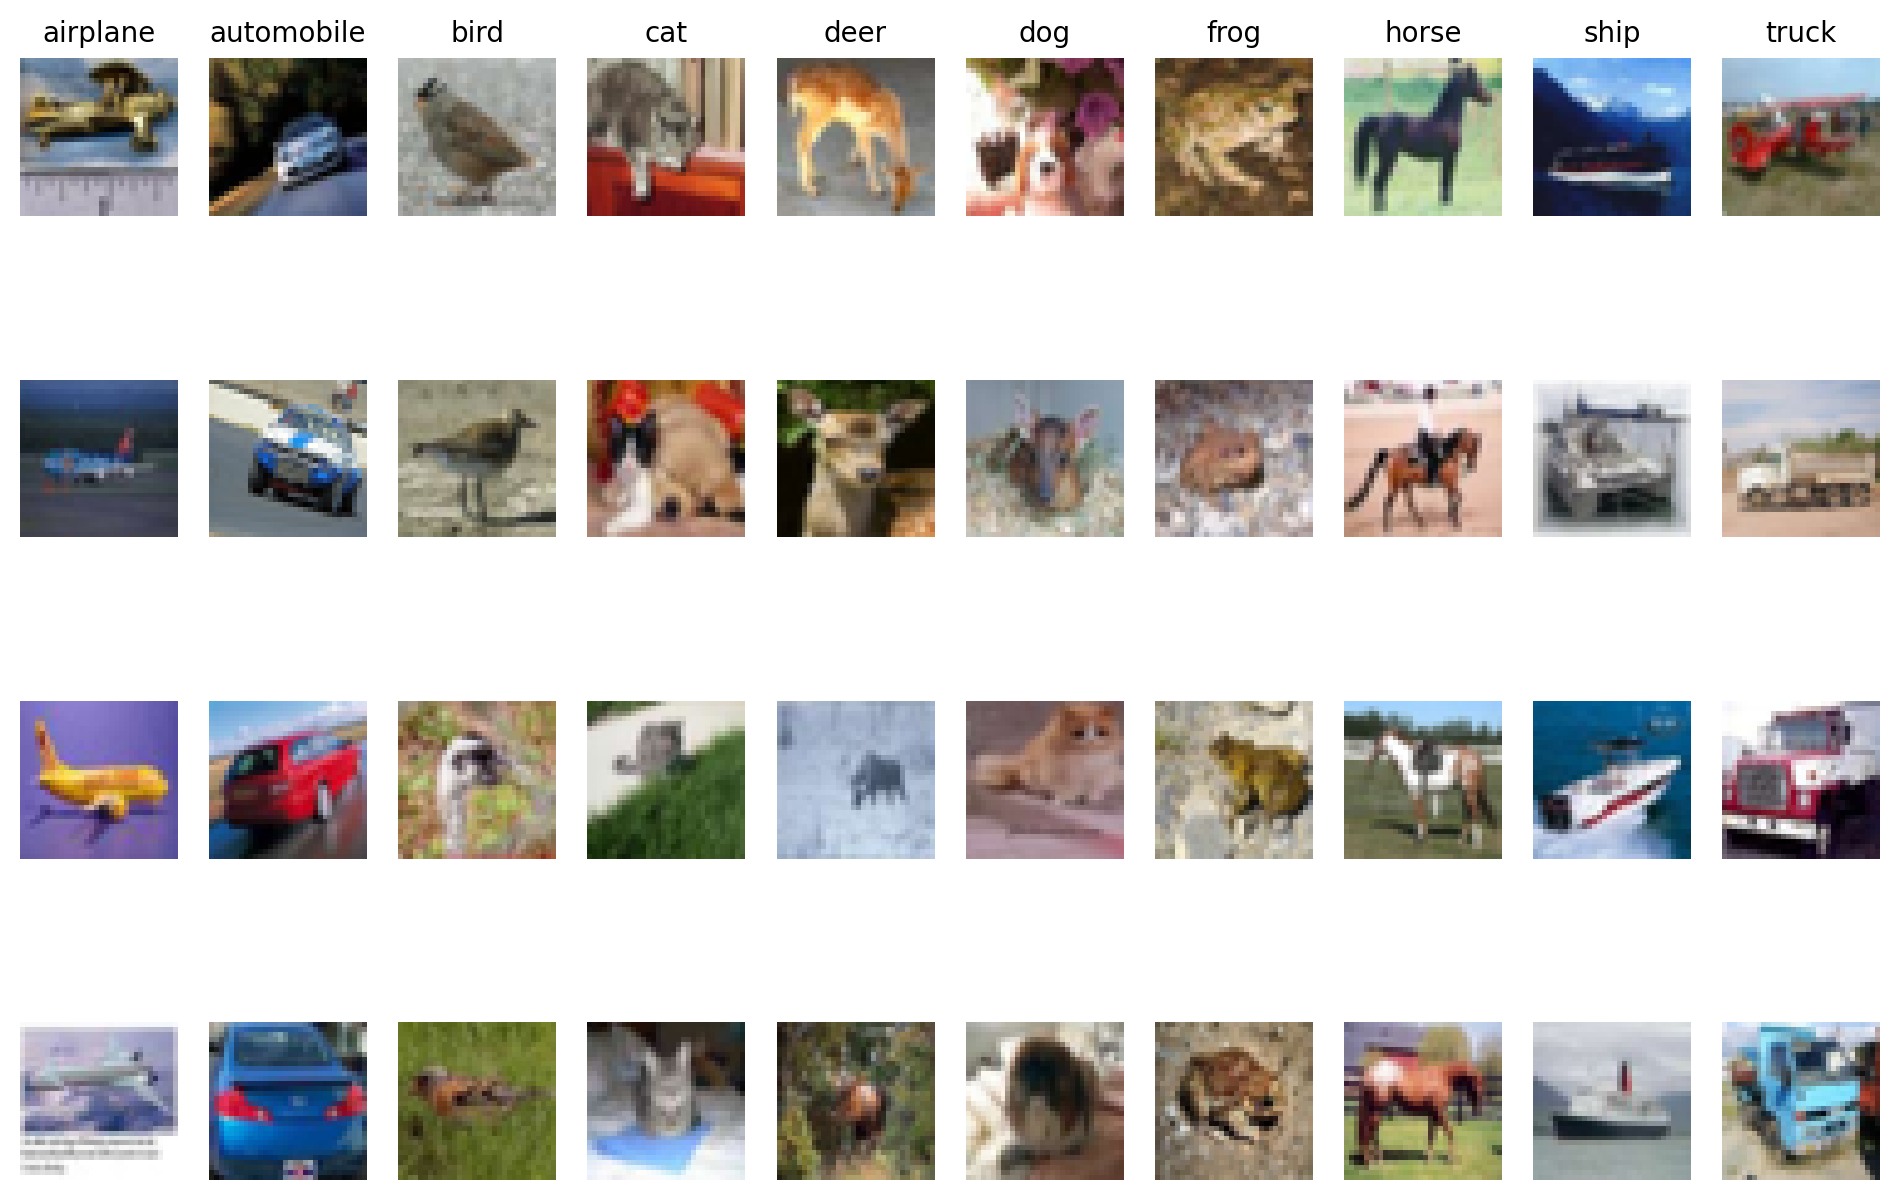

In [ ]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


# <font color=maroon>Model Building Tuned 4 - Efficient Net

### Import

In [3]:
from keras.datasets import cifar10

# load cifar 10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


### Data Preprocessing

In [4]:
IMG_SIZE = 224

# convert labels to one-hot encoded vectors
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# def format_image(image, label):

#     # Resize the image
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

#     # Apply data augmentation
#     image = tf.image.random_flip_left_right(image)  # Random horizontal flip
#     image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
#     image = tf.image.random_crop(image, size=[int(IMG_SIZE * 0.9), int(IMG_SIZE * 0.9), 3])  # Random crop to enable shift augmentation
#     image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize back after crop
    
    
#     return image, label

# def format_image2(image, label):
#     # Resize the image
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    
# # Create TensorFlow dataset objects for the training and test sets
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# batch_size = 64
# # Preprocess, batch, and prefetch the datasets
# train_set = train_ds.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
# test_set = test_ds.map(format_image2).batch(batch_size).prefetch(1)

# print(train_set)
# print(test_set)

def format_image(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    # Apply data augmentation
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.random_crop(image, size=[int(IMG_SIZE * 0.9), int(IMG_SIZE * 0.9), 3])  # Random crop to enable shift augmentation
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize back after crop

    return image, label

def format_image2(image, label):
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return image, label

batch_size = 64

# Create TensorFlow Datasets for training and testing
training_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply resizing, normalization, and data augmentation
train_set = training_set.shuffle(300).map(format_image).batch(batch_size).prefetch(1)
test_set = test_set.map(format_image2).batch(batch_size).prefetch(1)


### Build Transfer learning model
### <font color=purple>Changes Made</font>
- Use classes = 10 
- Removed scaling in preprocessing
- Removed additional 10 dense layer 
- Changed early stopping patience = 10
- Added learning rate scheduler.
- Increased epoch to 100 
- Added Image Augmentation

In [5]:
pre_model = tf.keras.applications.EfficientNetB0(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=10)
for layer in pre_model.layers:
    layer.trainable=True
    
pre_model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [6]:
# build EfficientNet model
model = Sequential(name='EfficientNet_Tuned_4')

model.add(tf.keras.layers.Rescaling(scale=255))
model.add(pre_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 100

# model.summary()

def decay(epoch):
    return 0.0001 / (1 + 1 * 30)

callback = []
callback += [keras.callbacks.LearningRateScheduler(decay)]

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss')

model_log = model.fit(train_set, 
                      epochs=EPOCHS,
                      validation_data=test_set,
                      callbacks=[early_stop, callback])

Epoch 1/100


2023-05-30 02:20:44.504277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet_Tuned_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 367s 401ms/step - loss: 2.1970 - accuracy: 0.2167 - val_loss: 1.9432 - val_accuracy: 0.4143 - lr: 3.2258e-06
Epoch 2/100
782/782 [==============================] - 313s 400ms/step - loss: 1.7348 - accuracy: 0.4703 - val_loss: 1.4538 - val_accuracy: 0.6334 - lr: 3.2258e-06
Epoch 3/100
782/782 [==============================] - 315s 402ms/step - loss: 1.3522 - accuracy: 0.5893 - val_loss: 1.0820 - val_accuracy: 0.7143 - lr: 3.2258e-06
Epoch 4/100
782/782 [==============================] - 313s 401ms/step - loss: 1.1128 - accuracy: 0.6465 - val_loss: 0.8622 - val_accuracy: 0.7536 - lr: 3.2258e-06
Epoch 5/100
782/782 [==============================] - 312s 399ms/step - loss: 0.9669 - accuracy: 0.6822 - val_loss: 0.7308 - val_accuracy: 0.7791 - lr: 3.2258e-06
Epoch 6/100
782/782 [==============================] - 313s 400ms/step - loss: 0.8684 - accuracy: 0.7115 - val_loss: 0.6388 - val_accuracy: 0.8054 - lr: 3.2258e-06
Epoch 7/100
782/782 [=======

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_set)
print('Test loss: ', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 11s 67ms/step - loss: 0.1578 - accuracy: 0.9451
Test loss:  0.15778259932994843
Test accuracy: 0.9451000094413757


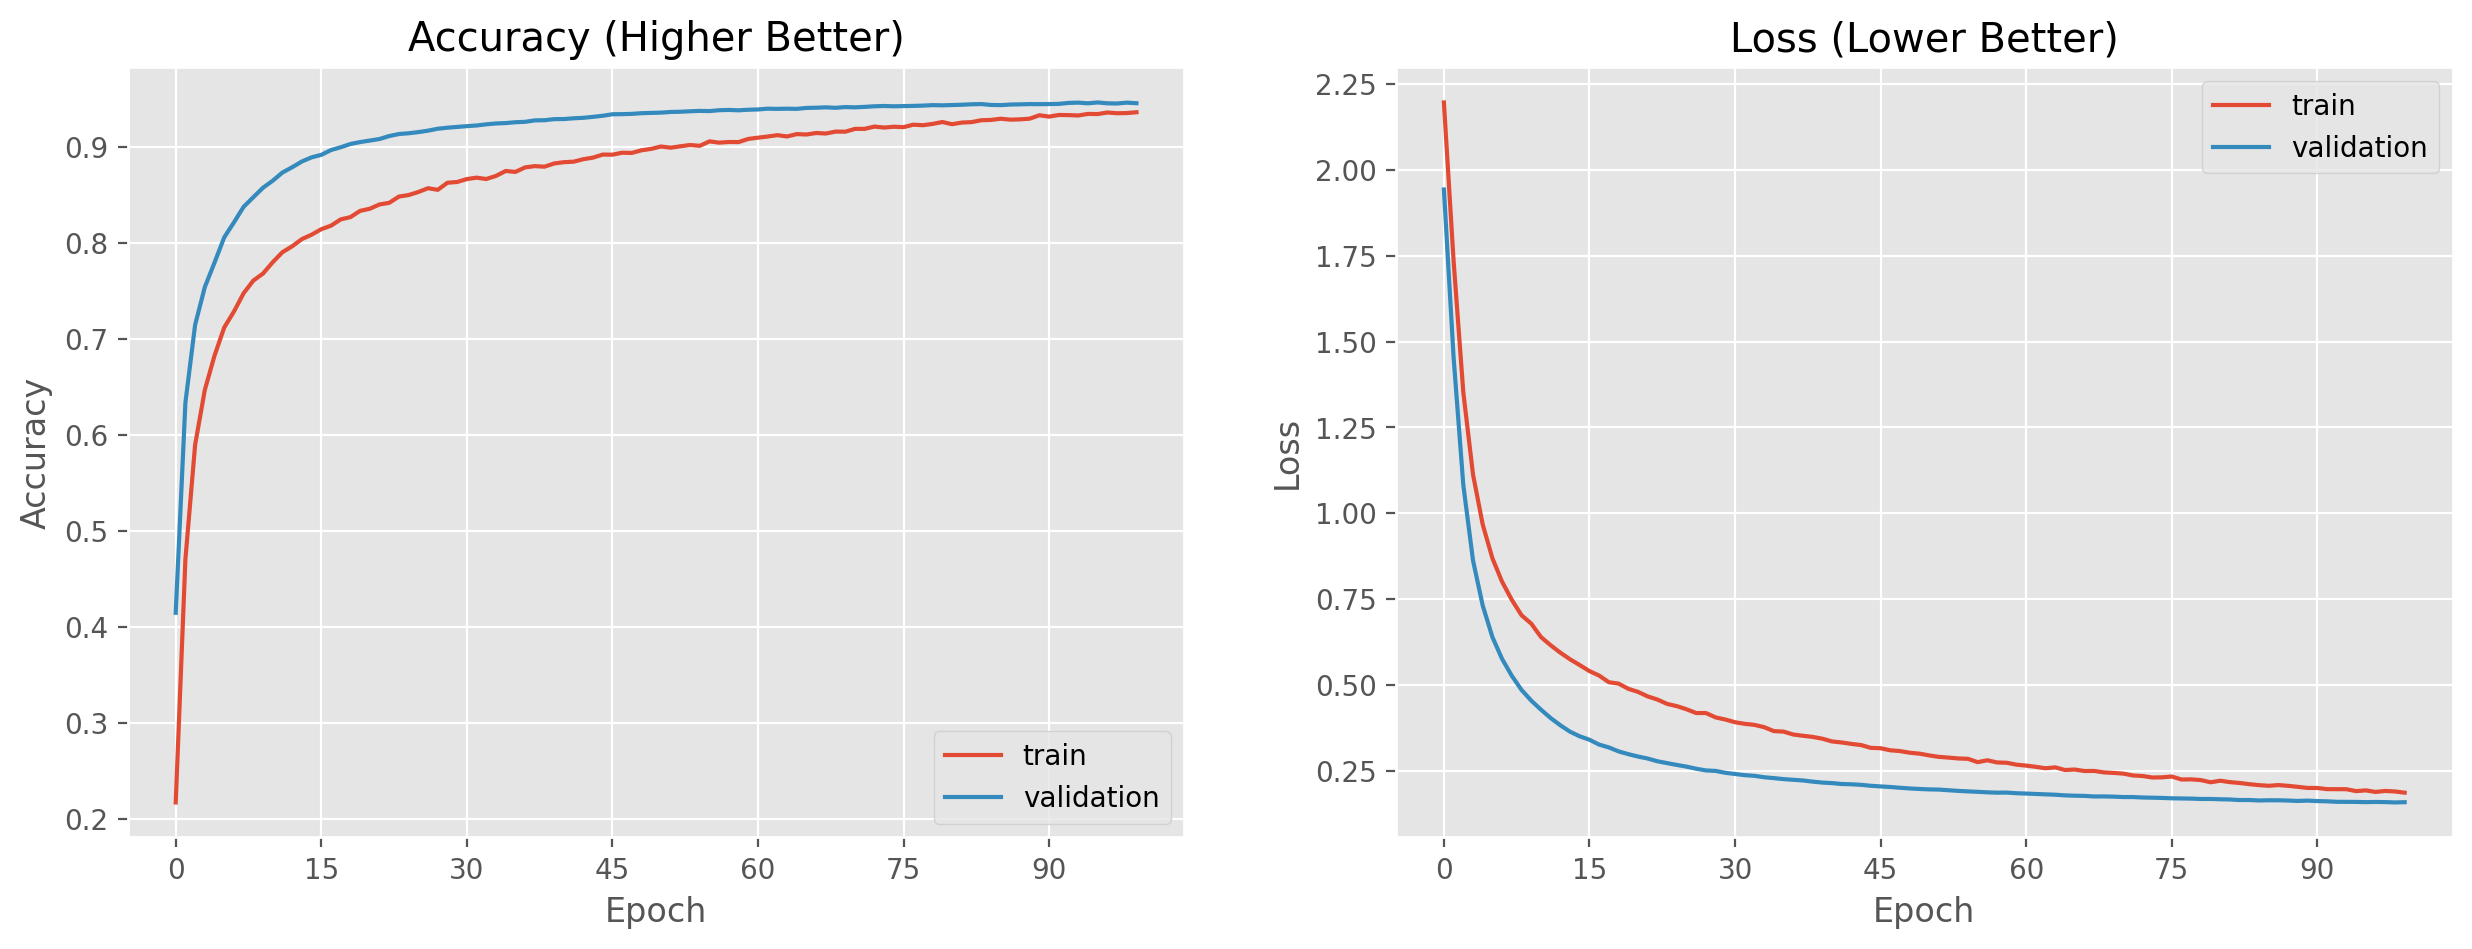

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

In [9]:
# Predict the test set
predict_x = model.predict(test_set)
output = np.argmax(predict_x, axis=1)
print(output)

157/157 [==============================] - 12s 64ms/step
[3 8 8 ... 5 1 7]


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
ind = np.where(np.equal(output, y_test)==0)

In [11]:
subset_size=1000
ind_subset = np.random.choice(ind[0], size=subset_size, replace=False)

err_x = x_test[ind_subset]
err_y = output[ind_subset]

In [12]:
print(err_x.shape)

(1000, 32, 32, 3)


/tmp/ipykernel_29/2615009037.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)


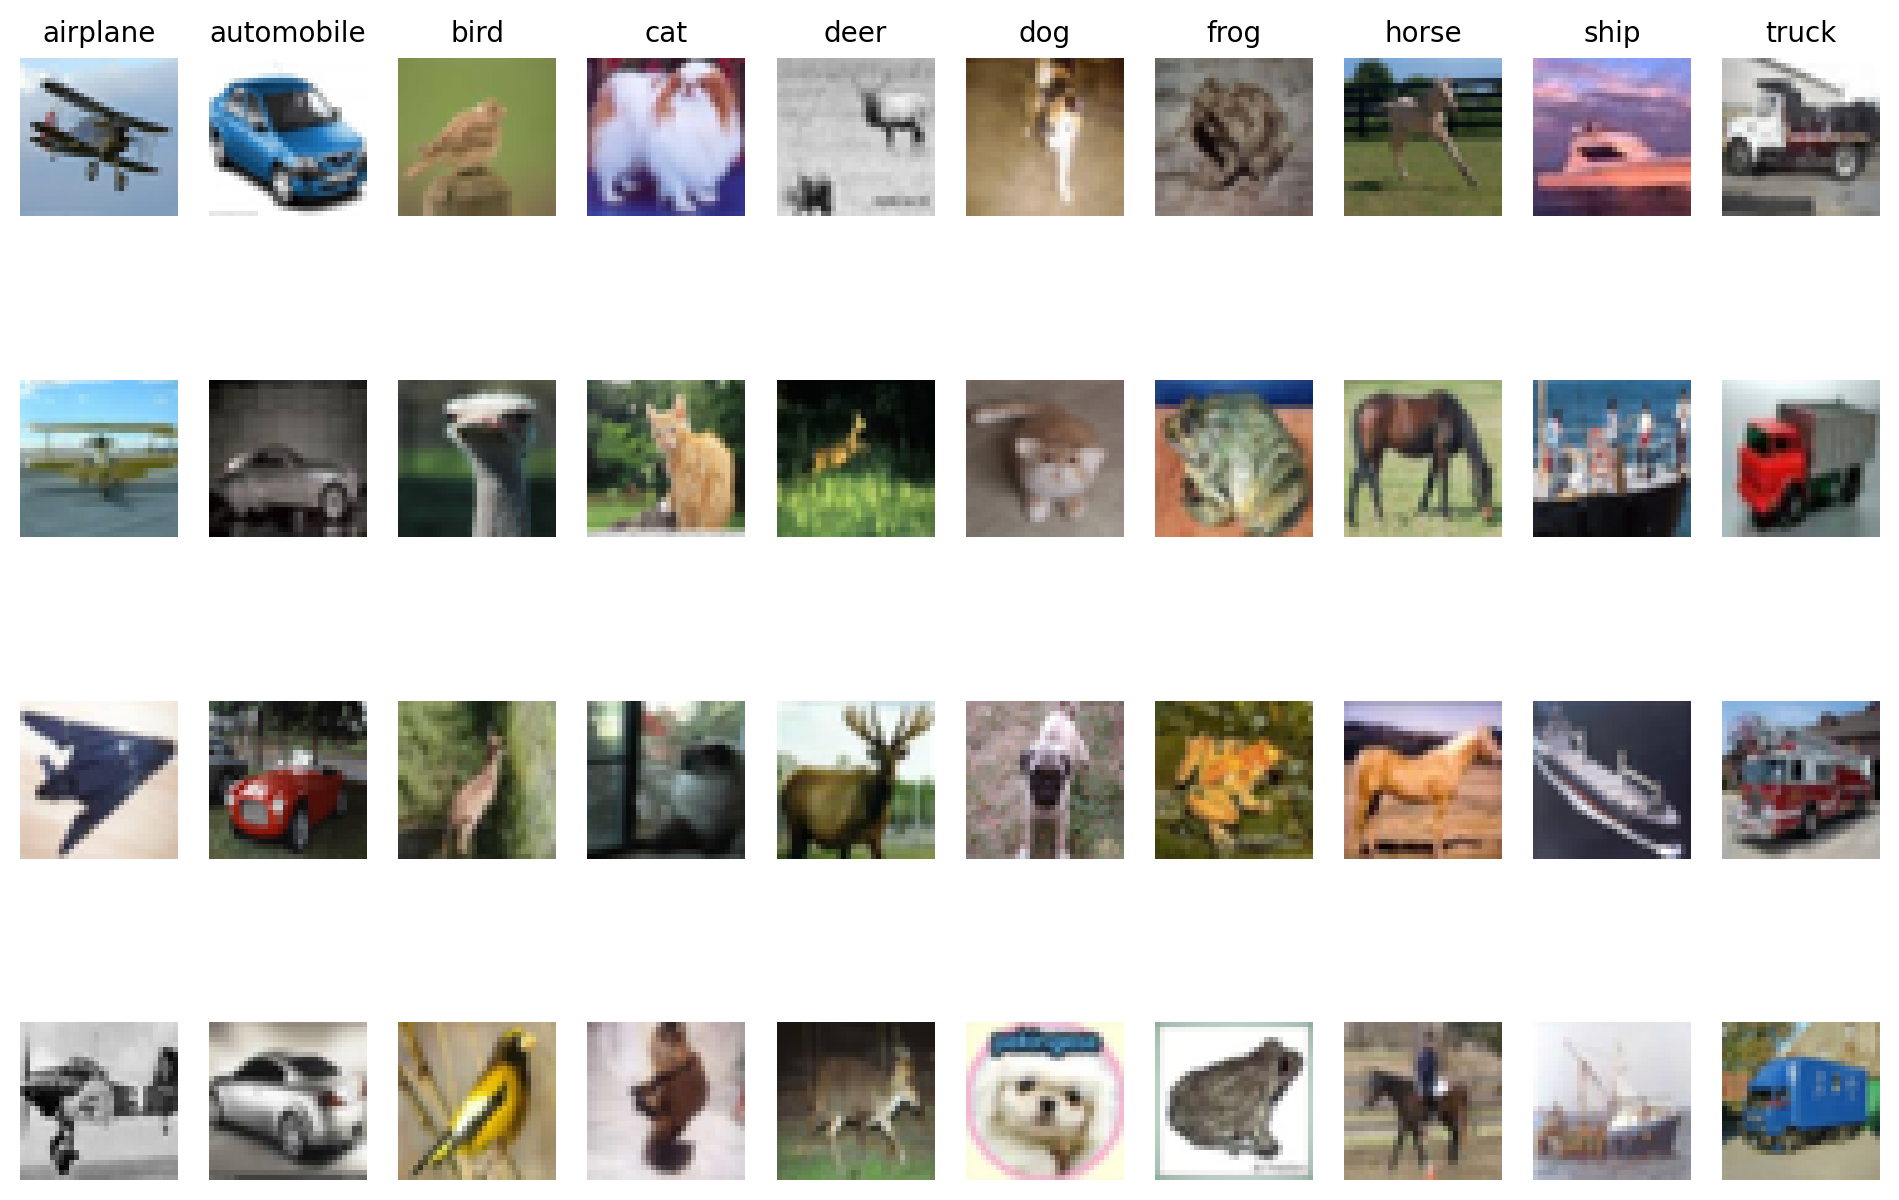

In [13]:
# Define class names
num_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# visualise some wrongly classified images
examples_per_class = 4
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
for cls, cls_name in enumerate(num_classes):
    idxs = np.where(cls == err_y)
    idxs = np.random.choice(idxs[0], examples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(num_classes), i * len(num_classes) + cls + 1)
        plt.imshow(err_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name, fontsize=10)


In [15]:
# convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [17]:
! pip install pyautogui

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyautogui: filename=PyAutoGUI-0.9.54-py3-none-any.whl size=37579 sha256=9f0c74616c851a0